In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch                                                                                                                                                                                                       
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

### Dataset creation

In [2]:
data_points = int(1e4)
noise_factor = 700

In [3]:
X = Variable(torch.linspace(9403, 18293, data_points)) # (data_points)
X = torch.unsqueeze(X, 1) # (data_points, 1)

y = Variable(torch.linspace(455, 2320, data_points))
y = torch.unsqueeze(y, 1)

noise = noise_factor * Variable(torch.randn(data_points))
y = y.add(noise)

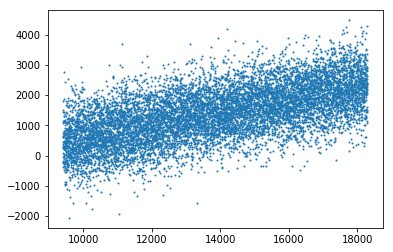

In [4]:
plt.scatter(X.data.numpy(), y.data.numpy(), s=1)
plt.show()

In [5]:
ds = data.TensorDataset(X.data, y.data)
data_loader = data.DataLoader(ds, batch_size=500,
                              shuffle=True,
                              num_workers=4)

### Classifier

In [6]:
class LinReg(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinReg, self).__init__()
        self.lin = nn.Linear(in_size, out_size)
        self.bn = nn.BatchNorm1d(in_size)
        
    def forward(self, X):
        out = self.lin(X)
        out = self.bn(out)
        return out
    
model = LinReg(1,1)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [7]:
%%time

n_epochs = 50
losses = []

for epoch in range(n_epochs):
    for (X_batch, y_batch) in data_loader:
        X_batch = Variable(X_batch)
        y_batch = Variable(y_batch)
        
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        losses.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

CPU times: user 5.83 s, sys: 27.2 s, total: 33.1 s
Wall time: 12.6 s


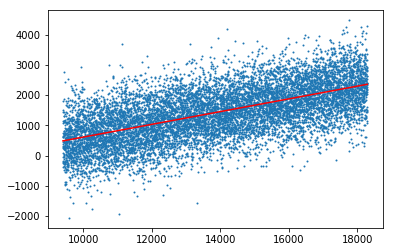

In [8]:
# Sets model to evaluation mode
model.eval()

y_pred = model(X)
plt.scatter(X.data.numpy(), y.data.numpy(), s=1)
plt.plot(X.data.numpy(), y_pred.data.numpy(), 'r')
plt.show()

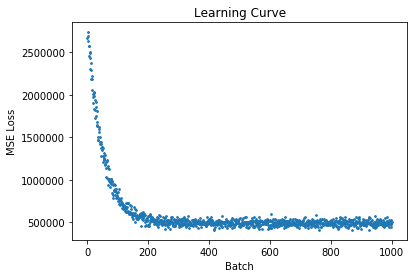

In [9]:
plt.title("Learning Curve")
plt.xlabel("Batch")
plt.ylabel("MSE Loss")
plt.scatter(np.linspace(1, len(losses), len(losses)), losses, s=3)
plt.show()

In [21]:
for i, module in enumerate(model.modules()):
    print(i, module)

0 LinReg (
  (lin): Linear (1 -> 1)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
)
1 Linear (1 -> 1)
2 BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)


In [25]:
list(model.lin.parameters())

[Parameter containing:
 -0.3865
 [torch.FloatTensor of size 1x1], Parameter containing:
 -0.7341
 [torch.FloatTensor of size 1]]

In [27]:
model.state_dict().keys()

odict_keys(['lin.weight', 'lin.bias', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var'])